# Model Evaluation 

## Agenda
1. Data Collection
2. Data Cleaning, Feature Engineering and Label Encoding
3. Model Evaluation
4. Data Prediction
5. Summary

# 1. Data Collection

**Import Required Packages**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import statistics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from scipy.stats import randint
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import joblib
import os
import gc

**Import the CSV Data as Pandas DataFrame**

In [2]:
start = time.time()
test = pd.read_csv("/kaggle/input/audio-engagement-challenge/test.csv")
train = pd.read_csv("/kaggle/input/audio-engagement-challenge/train.csv")
print("Files loaded in", time.time()-start, "seconds")

Files loaded in 2.2914137840270996 seconds


# 2. Data Cleaning, Feature Engineering and Label Encoding

*This part includes everything that was described in our EDA, so there is no explanation of what we did as it stated in our EDA*

In [3]:
X_train = train.drop(['id', 'Listening_Time_minutes'], axis=1)
Y_train = train['Listening_Time_minutes']
X_test = test.drop('id', axis=1)

In [4]:
X_train['Number_of_Ads']=X_train['Number_of_Ads'].fillna(X_train['Number_of_Ads'].median())
X_train['Number_of_Ads'].isna().sum()

0

**Replacing nullable data in `Guest_Popularity_percentage` with 0**

In [5]:
X_train['Guest_Popularity_percentage']=X_train['Guest_Popularity_percentage'].fillna(0)
X_train['Guest_Popularity_percentage'].isna().sum()

0

In [6]:
X_test['Guest_Popularity_percentage']=X_test['Guest_Popularity_percentage'].fillna(0)
X_test['Guest_Popularity_percentage'].isna().sum()

0

**Using Simple Encoder**

In [7]:
imputer = SimpleImputer(strategy='median')
num_without_id = ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads']
X_train[num_without_id] = imputer.fit_transform(train[num_without_id])
print(f"Training data has been transformed")
X_test[num_without_id] = imputer.transform(test[num_without_id])
print(f"Testing data has been transformed")

Training data has been transformed
Testing data has been transformed


**Handling outliers**

In [8]:
def find_anomalies(data):
    anomalies=[]
    data_std = statistics.stdev(data)
    data_mean = statistics.mean(data)
    anomaly_cut_off = data_std * 3
    lower_limit = data_mean - anomaly_cut_off
    upper_limit = data_mean +anomaly_cut_off
    for outlier in data:
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(outlier)
            print(f"The value of the outlier: {outlier}")
    return anomalies

def list_outliers(data, columns):
    anomalies = []
    for col in columns:
        outliers = find_anomalies(data[col])
        print(f"In the {col} column there are {len(outliers)} outliers")
        anomalies.append((col, outliers))
    return anomalies

In [9]:
print("Train outliers:")
train_anomalies = list_outliers(X_train, num_without_id)
print("Test outliers:")
test_anomalies = list_outliers(X_test, num_without_id)

Train outliers:
The value of the outlier: 325.24
In the Episode_Length_minutes column there are 1 outliers
In the Host_Popularity_percentage column there are 0 outliers
In the Guest_Popularity_percentage column there are 0 outliers
The value of the outlier: 53.37
The value of the outlier: 103.91
The value of the outlier: 103.0
The value of the outlier: 53.42
The value of the outlier: 103.75
The value of the outlier: 12.0
The value of the outlier: 103.25
The value of the outlier: 103.25
The value of the outlier: 103.88
In the Number_of_Ads column there are 9 outliers
Test outliers:
The value of the outlier: 78486264.0
In the Episode_Length_minutes column there are 1 outliers
In the Host_Popularity_percentage column there are 0 outliers
In the Guest_Popularity_percentage column there are 0 outliers
The value of the outlier: 89.12
The value of the outlier: 2063.0
In the Number_of_Ads column there are 2 outliers


In [10]:
def replace(data, value_up, value_low, columns):
    data_copy = data.copy()
    for column in columns:
        up_mask = data_copy[column] > value_up
        if up_mask.any():
            data_copy.loc[up_mask, column] = value_up
            print(f"{column}: replaced {up_mask.sum()} values with {value_up}")
        low_mask = data_copy[column] < value_low
        if low_mask.any():
            data_copy.loc[low_mask, column] = value_low
            print(f"{column}: replaced {low_mask.sum()} values with {value_low}")
    return data_copy

In [11]:
X_train_num = X_train[num_without_id]
X_test_num = X_test[num_without_id]
percentage_cols = ['Guest_Popularity_percentage', 'Host_Popularity_percentage']
X_train[num_without_id]= replace(X_train_num, 100,0,percentage_cols)
X_test[num_without_id] = replace(X_test_num, 100,0,percentage_cols)

Guest_Popularity_percentage: replaced 19 values with 100
Host_Popularity_percentage: replaced 25 values with 100
Guest_Popularity_percentage: replaced 5 values with 100
Host_Popularity_percentage: replaced 12 values with 100


In [12]:
def replace_outliers(train_data, test_data, columns):
    data_replaced_train = train_data.copy()
    data_replaced_test = test_data.copy()
    for column in columns:
        col_data_train = train_data[column]
        data_std = statistics.stdev(col_data_train)
        data_mean = statistics.mean(col_data_train)
        anomaly_cut_off = data_std * 3
        lower_limit = round(data_mean - anomaly_cut_off, 2)
        upper_limit = round(data_mean + anomaly_cut_off, 2)
        data_replaced_train = replace(data_replaced_train, upper_limit, lower_limit, [column])
        data_replaced_test = replace(data_replaced_test, upper_limit, lower_limit, [column])
    return data_replaced_train, data_replaced_test

In [13]:
outlier_cols = ['Episode_Length_minutes', 'Number_of_Ads']
X_train_replaced, X_test_replaced = replace_outliers(X_train, X_test, outlier_cols)
X_train_replaced = X_train_replaced.round({'Number_of_Ads':0})
X_test_replaced = X_test_replaced.round({'Number_of_Ads':0})
X_test = X_test_replaced
X_train = X_train_replaced

Episode_Length_minutes: replaced 1 values with 157.42
Episode_Length_minutes: replaced 2 values with 157.42
Number_of_Ads: replaced 9 values with 4.8
Number_of_Ads: replaced 2 values with 4.8


**`Episode_Title` to numerical column**

In [14]:
X_train['Episode_Title'] = X_train['Episode_Title'].str.extract('(\d+)').astype(int)
X_train['Episode_Title'].head()

0    98
1    26
2    16
3    45
4    86
Name: Episode_Title, dtype: int64

In [15]:
X_test['Episode_Title'] = X_test['Episode_Title'].str.extract('(\d+)').astype(int)
X_test['Episode_Title'].head()

0    73
1    23
2    11
3    73
4    50
Name: Episode_Title, dtype: int64

**Feature Engineering**

In [16]:
X_train['Ads_per_Popularity'] = X_train['Number_of_Ads'] / (X_train['Host_Popularity_percentage'] + 0.1)
X_test['Ads_per_Popularity'] = X_test['Number_of_Ads'] / (X_test['Host_Popularity_percentage'] + 0.1)
X_train['Length_Ads_Ratio'] = X_train['Episode_Length_minutes'] / (X_train['Number_of_Ads'] + 1)
X_test['Length_Ads_Ratio'] = X_test['Episode_Length_minutes'] / (X_test['Number_of_Ads'] + 1)
X_train['Length_Popularity_Interaction'] = X_train['Episode_Length_minutes'] * (X_train['Host_Popularity_percentage']+X_train['Guest_Popularity_percentage'])
X_test['Length_Popularity_Interaction'] = X_test['Episode_Length_minutes'] * (X_test['Host_Popularity_percentage']+X_test['Guest_Popularity_percentage'])

**Label Encoding**

In [17]:
ordinal_columns = ['Episode_Sentiment', 'Publication_Day', 'Publication_Time', 'Podcast_Name', 'Genre']

label_encoders = {}
for col in ordinal_columns:
    le = LabelEncoder()
    X_train[f'{col}_Encoded'] = le.fit_transform(X_train[col])
    X_test[f'{col}_Encoded'] = le.transform(X_test[col])
    label_encoders[col] = le
X_train = X_train.drop(ordinal_columns, axis=1)
X_test = X_test.drop(ordinal_columns, axis=1)

# 3. Model Choosing

Some features have very low correlation with target, so it is important to try not-linear models, such as:
1. Tree-Based Models
2. Gradient Boosting
3. Ensemble Methods

### Splitting training set into validation and training sets

In [18]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42
)

Tuning LightGBM...
Tuning XGBoost...
Tuning CatBoost...
Tuning Random Forest...
Training LightGBM...
Training XGBoost...
Training CatBoost...
Training RandomForest...

MODEL COMPARISON RESULTS

LightGBM:
RMSE: 13.0289
Best Parameters: {'learning_rate': 0.2, 'max_depth': None, 'n_estimators': 124, 'subsample': 0.8}

XGBoost:
RMSE: 12.9366
Best Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 87, 'reg_lambda': 5}

CatBoost:
RMSE: 13.0317
Best Parameters: {'depth': 10, 'iterations': 153, 'l2_leaf_reg': 5, 'learning_rate': 0.2}

RandomForest:
RMSE: 12.6698
Best Parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_split': 4, 'n_estimators': 124}

FINAL RANKING (Best to Worst)
1. RandomForest: RMSE = 12.6698
2. XGBoost: RMSE = 12.9366
3. LightGBM: RMSE = 13.0289
4. CatBoost: RMSE = 13.0317


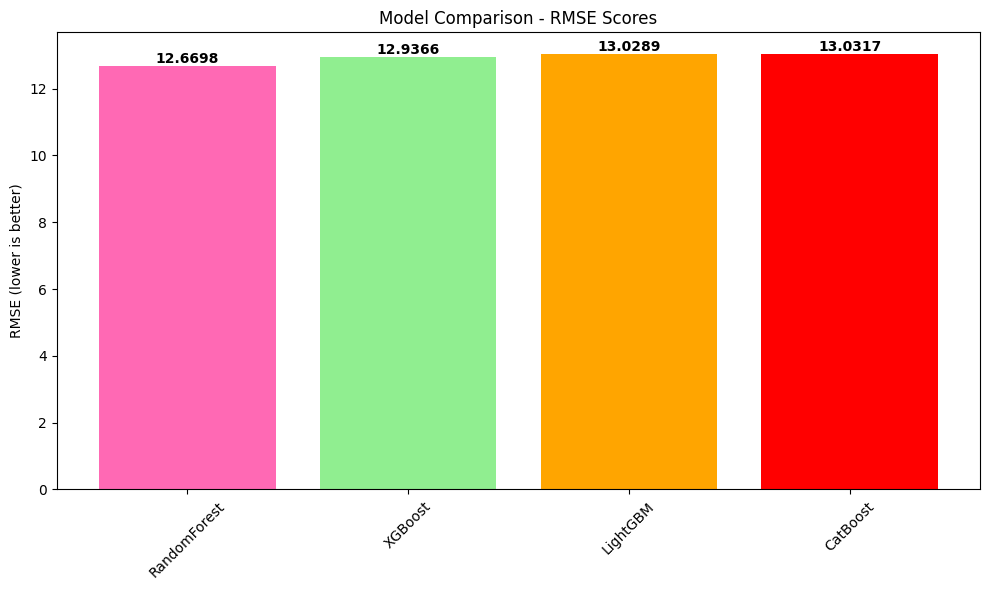


BEST MODEL: RandomForest
RMSE: 12.6698
Parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_split': 4, 'n_estimators': 124}


In [19]:
def create_and_validate_ensemble(X_tr, X_val, y_tr, y_val):
    param_grid_lgd = {
        'n_estimators': randint(50, 200),
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [7, 10, None],
        'subsample': [0.8, 0.9]
    }

    param_grid_xgb = {
        'n_estimators': randint(50, 200),
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [7, 10, None],
        'reg_lambda': [1, 5]
    }

    param_grid_cat = {
        'iterations': randint(50, 200),
        'learning_rate': [0.05, 0.1, 0.2],
        'depth': [8, 10],
        'l2_leaf_reg': [3, 5]
    }

    param_dist_rf = {
        'n_estimators': randint(50, 200),
        'max_depth': [10, 15, None],
        'min_samples_split': randint(2, 10),
        'max_features': ['sqrt', 'log2']
    }

    print("Tuning LightGBM...")
    lgb = LGBMRegressor(random_state=42, verbose=-1, n_jobs=1)
    random_search_lgd = RandomizedSearchCV(
        lgb, param_grid_lgd, n_iter=8, cv=3, n_jobs=-1, 
        random_state=42, verbose=0
    )
    random_search_lgd.fit(X_tr, y_tr)
    best_params_lgd = random_search_lgd.best_params_

    print("Tuning XGBoost...")
    xgb = XGBRegressor(random_state=42, n_jobs=1)
    random_search_xgb = RandomizedSearchCV(
        xgb, param_grid_xgb, n_iter=8, cv=3, n_jobs=-1, 
        random_state=42, verbose=0
    )
    random_search_xgb.fit(X_tr, y_tr)
    best_params_xgb = random_search_xgb.best_params_

    print("Tuning CatBoost...")
    catboost = CatBoostRegressor(random_seed=42, verbose=False, thread_count=1)
    random_search_cat = RandomizedSearchCV(
        catboost, param_grid_cat, n_iter=8, cv=3, n_jobs=1, 
        random_state=42, verbose=0
    )
    random_search_cat.fit(X_tr, y_tr)
    best_params_cat = random_search_cat.best_params_

    print("Tuning Random Forest...")
    rf = RandomForestRegressor(random_state=42, n_jobs=1)
    random_search_rf = RandomizedSearchCV(
        rf, param_dist_rf, n_iter=8, cv=3, n_jobs=1, 
        random_state=42, verbose=0
    )
    random_search_rf.fit(X_tr, y_tr)
    best_rf_params = random_search_rf.best_params_

    models = {
        'LightGBM': LGBMRegressor(**best_params_lgd, random_state=42, n_jobs=1),
        'XGBoost': XGBRegressor(**best_params_xgb, random_state=42, n_jobs=1),
        'CatBoost': CatBoostRegressor(**best_params_cat, random_seed=42, verbose=False),
        'RandomForest': RandomForestRegressor(**best_rf_params, random_state=42, n_jobs=1),
    }

    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_tr, y_tr)

    return models, {
        'LightGBM': best_params_lgd,
        'XGBoost': best_params_xgb,
        'CatBoost': best_params_cat,
        'RandomForest': best_rf_params
    }

def compare_models(models, X_val, y_val, best_params):
    print("\n" + "="*60)
    print("MODEL COMPARISON RESULTS")
    print("="*60)
    
    results = []
    
    for name, model in models.items():
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        
        results.append({
            'Model': name,
            'RMSE': rmse,
            'Best_Params': best_params[name]
        })
        
        print(f"\n{name}:")
        print(f"RMSE: {rmse:.4f}")
        print(f"Best Parameters: {best_params[name]}")

    results.sort(key=lambda x: x['RMSE'])
    
    print("\n" + "="*60)
    print("FINAL RANKING (Best to Worst)")
    print("="*60)
    
    for i, result in enumerate(results, 1):
        print(f"{i}. {result['Model']}: RMSE = {result['RMSE']:.4f}")

    plt.figure(figsize=(10, 6))
    models_names = [r['Model'] for r in results]
    rmse_scores = [r['RMSE'] for r in results]
    
    bars = plt.bar(models_names, rmse_scores, color=['hotpink', 'lightgreen', 'orange', 'red'])
    plt.ylabel('RMSE (lower is better)')
    plt.title('Model Comparison - RMSE Scores')
    plt.xticks(rotation=45)
    
    for bar, score in zip(bars, rmse_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, f'{score:.4f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

    return results

models, best_params = create_and_validate_ensemble(X_tr, X_val, y_tr, y_val)
results = compare_models(models, X_val, y_val, best_params)

best_model = results[0]
print(f"\nBEST MODEL: {best_model['Model']}")
print(f"RMSE: {best_model['RMSE']:.4f}")
print(f"Parameters: {best_model['Best_Params']}")

First, we used RandomizedSearchCV to find the best parameters for LGBMRegressor, XGBRegressor, CatBoostRegressor, and RandomForestRegressor. We then implemented Voting and Stacking ensembles using the parameters and models from the previous step. RandomForestRegressor achieved the best RMSE, outperforming even the ensemble scores during validation, so we decided to focus on this model.

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters for RandomForest: {'max_depth': None, 'max_features': 'log2', 'min_samples_split': 4, 'n_estimators': 124}


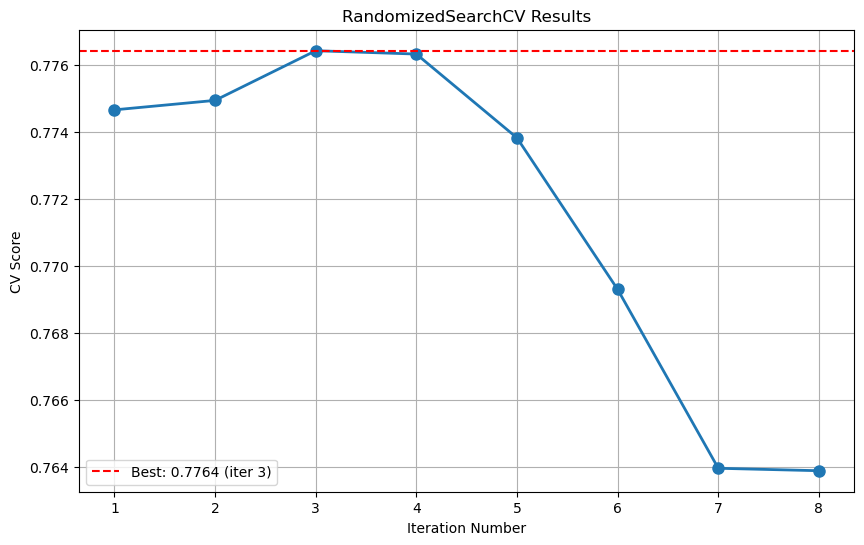

In [ ]:
def evaluate_best(X_tr, y_tr):
    param_dist = {
        'n_estimators': randint(50, 200),
        'max_depth': [10, 15, None],
        'min_samples_split': randint(2, 10),
        'max_features': ['sqrt', 'log2']
    }

    rf = RandomForestRegressor(random_state=42)
    random_search = RandomizedSearchCV(
        rf, param_dist, n_iter=8, cv=3,
        n_jobs=-1, verbose=1, random_state=42,
        return_train_score=True
    )
    random_search.fit(X_tr, y_tr)
    best_rf_params = random_search.best_params_
    print(f'Best parameters for RandomForest: {best_rf_params}')
    
    results = pd.DataFrame(random_search.cv_results_)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 9), results['mean_test_score'], 'o-', linewidth=2, markersize=8)
    plt.xlabel('Iteration Number')
    plt.ylabel('CV Score')
    plt.title('RandomizedSearchCV Results')
    plt.grid(True)
    plt.xticks(range(1, 9))
    
    # Best score
    best_score = random_search.best_score_
    best_iter = random_search.best_index_ + 1
    plt.axhline(y=best_score, color='red', linestyle='--', 
                label=f'Best: {best_score:.4f} (iter {best_iter})')
    plt.legend()
    
    plt.show()
    
    model = RandomForestRegressor(**best_rf_params, random_state=42)
    return model, best_rf_params

model, best_rf_params = evaluate_best(X_train, Y_train)

**Best result:** 0.7764 (iteration 3)

**Result range:** 0.764 - 0.776 (difference 0.012)

**Best parameters for RandomForest:** {'max_depth': None, 'max_features': 'log2', 'min_samples_split': 4, 'n_estimators': 124}


--- MODEL TRAINING ---


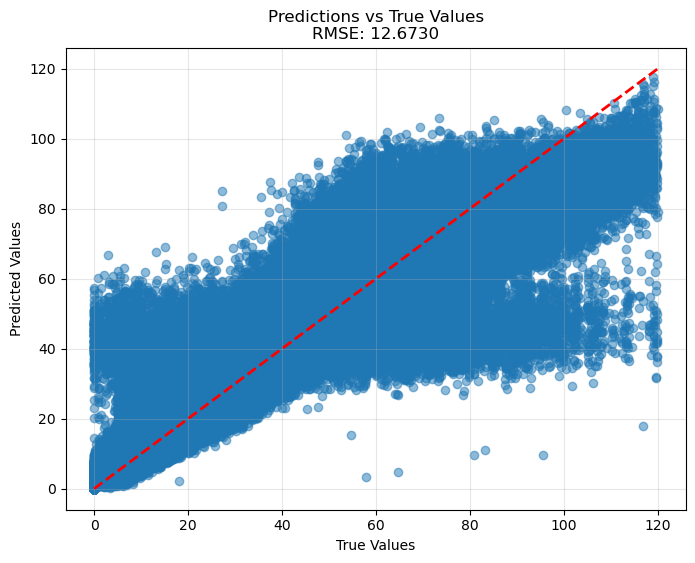

RMSE: 12.6730


In [ ]:
def train_and_evaluate_model(model, X_tr, y_tr, X_val, y_val):
    
    print(f"\n--- MODEL TRAINING ---")
        
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    # Predictions
    plt.figure(figsize=(8, 6))
    plt.scatter(y_val, y_pred, alpha=0.5)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Predictions vs True Values\nRMSE: {rmse:.4f}')
    plt.grid(True, alpha=0.3)
    plt.show()
    print(f"RMSE: {rmse:.4f}")
    
    return y_pred, rmse

y_pred, rmse = train_and_evaluate_model(model, X_tr, y_tr, X_val, y_val)

#### Insights:
The RMSE of RandomForestRegressor is 12.67304

In Kaggle it was 12.62

Points located close to the diagonal are a good sign

Minimal scatter around the ideal prediction line

Then we thinking of how we can improve the performance of the model. We have been trying to biuld ensemble from forests with this code:
```python
forests = [
         RandomForestRegressor(**best_rf_params, random_state=i, n_jobs=-1)
         for i in range(5)
     ]
```
This model performed better than others, but the main issues are optimization and high memory usage. Increasing the number of forests will likely cause a memory error. Then we tried BaggingRegressor as it creates many "weaker" models on different data samples and averages their predictions to get a more robust final prediction. But BaggingRegressor wasn't so good, the best RMSE score was 12.7 and we also had some memory issues. 

We decided to optimize memory usage by saving model configs to disk and loading them only for predictions using array for results and deleting forest after adding the result to the array.

In [31]:
models_dir = "saved_models"
os.makedirs(models_dir, exist_ok=True)

In [ ]:
def save_untrained_models(models_dir, best_params, n_models=30):
    # Creating one base config
    base_config = {
        'model_type': 'RandomForestRegressor',
        'base_params': best_params
    }
    
    # Saving config
    joblib.dump(base_config, f'{models_dir}/base_config.joblib')
    
    # Saving only random_state for each model
    for i in range(n_models):
        model_info = {
            'random_state': i,
            'n_jobs': 3
        }
        
        filename = f'{models_dir}/model_{i}.joblib'
        joblib.dump(model_info, filename)
        
        print(f"Model config {i+1} saved")
    
    print(f"All {n_models} model configurations saved")

def load_and_train_predict(models_dir, X_tr, X_val, y_tr, y_val):
    predictions = []
    model_files = []
    
    for file in os.listdir(models_dir):
        if file.startswith('model_') and file.endswith('.joblib'):
            model_files.append(file)
    
    model_files.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))
    base_config = joblib.load(f'{models_dir}/base_config.joblib')
    
    for i, file in enumerate(model_files):
        model_info = joblib.load(f'{models_dir}/model_{i}.joblib')
        
        params = {**base_config['base_params'], 
                 'random_state': model_info['random_state'],
                 'n_jobs': model_info.get('n_jobs', 3)}
        
        forest = RandomForestRegressor(**params)        
        forest.fit(X_tr, y_tr)
        pred = forest.predict(X_val)
        predictions.append(pred)
        
        print(f"Model {i+1} trained and predicted")
        
        del forest, params
        gc.collect()
    
    final_prediction = np.mean(predictions, axis=0)
    rmse = np.sqrt(mean_squared_error(y_val, final_prediction))
    
    print(f"Final RMSE: {rmse:.4f}")
    return rmse

def create_and_validate_forests_disk_optimized(X_tr, X_val, y_tr, y_val, models_dir, best_params, n_models=30):
    save_untrained_models(models_dir, best_params, n_models)
    rmse = load_and_train_predict(models_dir, X_tr, X_val, y_tr, y_val)
    
    return rmse

rmse = create_and_validate_forests_disk_optimized(
    X_tr, X_val, y_tr, y_val, models_dir, best_rf_params, n_models=30
)

Model config 1 saved
Model config 2 saved
Model config 3 saved
Model config 4 saved
Model config 5 saved
Model config 6 saved
Model config 7 saved
Model config 8 saved
Model config 9 saved
Model config 10 saved
Model config 11 saved
Model config 12 saved
Model config 13 saved
Model config 14 saved
Model config 15 saved
Model config 16 saved
Model config 17 saved
Model config 18 saved
Model config 19 saved
Model config 20 saved
Model config 21 saved
Model config 22 saved
Model config 23 saved
Model config 24 saved
Model config 25 saved
Model config 26 saved
Model config 27 saved
Model config 28 saved
Model config 29 saved
Model config 30 saved
All 30 model configurations saved
Model 1 trained and predicted
Model 2 trained and predicted
Model 3 trained and predicted
Model 4 trained and predicted
Model 5 trained and predicted
Model 6 trained and predicted
Model 7 trained and predicted
Model 8 trained and predicted


At first, we tried to build this ensemble this 10 forests and then increase the number, the observation was that when increasing the number of models, the RMSE score decreases, that was the good news. But it doesn't make sense to build very big amounts of the forests because the difference between scores decreases with larger ensembles, so we stopped at 30 forests. 

# 4. Data Prediction

Model 1 predicted - Ensemble size: 1
Model 2 predicted - Ensemble size: 2
Model 3 predicted - Ensemble size: 3
Model 4 predicted - Ensemble size: 4
Model 5 predicted - Ensemble size: 5
Model 6 predicted - Ensemble size: 6
Model 7 predicted - Ensemble size: 7
Model 8 predicted - Ensemble size: 8
Model 9 predicted - Ensemble size: 9
Model 10 predicted - Ensemble size: 10
Model 11 predicted - Ensemble size: 11
Model 12 predicted - Ensemble size: 12
Model 13 predicted - Ensemble size: 13
Model 14 predicted - Ensemble size: 14
Model 15 predicted - Ensemble size: 15
Model 16 predicted - Ensemble size: 16
Model 17 predicted - Ensemble size: 17
Model 18 predicted - Ensemble size: 18
Model 19 predicted - Ensemble size: 19
Model 20 predicted - Ensemble size: 20
Model 21 predicted - Ensemble size: 21
Model 22 predicted - Ensemble size: 22
Model 23 predicted - Ensemble size: 23
Model 24 predicted - Ensemble size: 24
Model 25 predicted - Ensemble size: 25
Model 26 predicted - Ensemble size: 26
Mode

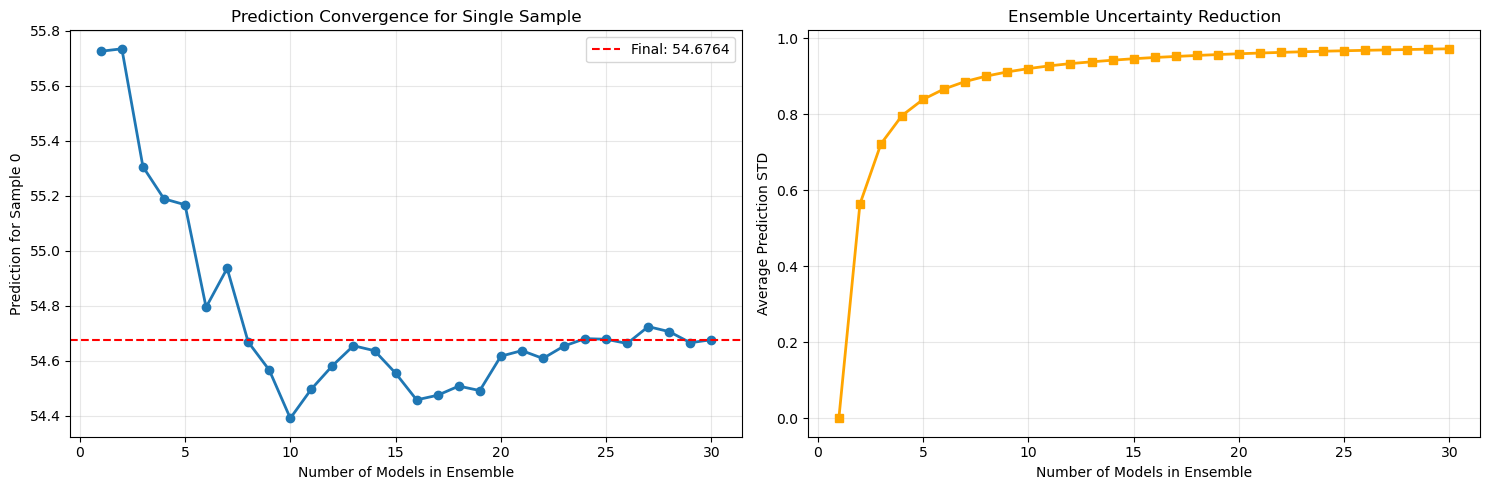

In [ ]:
def predict_from_disk_test(models_dir, X_test, X_train, Y_train):
    predictions = []
    model_files = []
    prediction_means = []
    prediction_stds = []
    
    for file in os.listdir(models_dir):
        if file.startswith('model_') and file.endswith('.joblib'):
            model_files.append(file)
    
    model_files.sort(key=lambda x: int(x.split('_')[1].split('.')[0]))
    base_config = joblib.load(f'{models_dir}/base_config.joblib')
    
    for i, file in enumerate(model_files):
        model_info = joblib.load(f'{models_dir}/model_{i}.joblib')
        
        params = {**base_config['base_params'], 
                 'random_state': model_info['random_state'],
                 'n_jobs': model_info.get('n_jobs', 3)}
        
        forest = RandomForestRegressor(**params)  
        forest.fit(X_train, Y_train)
        pred = forest.predict(X_test)
        predictions.append(pred)
        
        current_ensemble = np.mean(predictions, axis=0)
        current_std = np.std(predictions, axis=0)
        
        prediction_means.append(current_ensemble)
        prediction_stds.append(current_std)
        
        print(f"Model {i+1} predicted - Ensemble size: {len(predictions)}")
        
        del forest
        gc.collect()
    
    final_prediction = np.mean(predictions, axis=0)
    
    plt.figure(figsize=(15, 5))
    
    # Average prediction
    plt.subplot(1, 2, 1)
    sample_idx = 0
    ensemble_progress = [pred_mean[sample_idx] for pred_mean in prediction_means]
    plt.plot(range(1, len(ensemble_progress) + 1), ensemble_progress, 'o-', linewidth=2)
    plt.axhline(y=final_prediction[sample_idx], color='red', linestyle='--', 
                label=f'Final: {final_prediction[sample_idx]:.4f}')
    plt.xlabel('Number of Models in Ensemble')
    plt.ylabel(f'Prediction for Sample {sample_idx}')
    plt.title('Prediction Convergence for Single Sample')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Standard devation
    plt.subplot(1, 2, 2)
    mean_stds = [np.mean(pred_std) for pred_std in prediction_stds]
    plt.plot(range(1, len(mean_stds) + 1), mean_stds, 's-', color='orange', linewidth=2)
    plt.xlabel('Number of Models in Ensemble')
    plt.ylabel('Average Prediction STD')
    plt.title('Ensemble Uncertainty Reduction')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
        
    return final_prediction
prediction = predict_from_disk_test(models_dir, X_test, X_train, Y_train)

**Prediction Convergence for Single Sample**
- Prediction stabilized around the value of ~54.68
- Fast convergence - changes become minimal after 10-15 models
- Minor fluctuations in the beginning, then stabilization

**Ensemble Uncertainty Reduction**
- Standard deviation decreases as the ensemble grows
- Uncertainty reduces - models agree with each other

### Saving predictions

In [27]:

results = pd.DataFrame({
        'id': range(750000, 750000 + len(prediction)),
        'Listening_Time_minutes': prediction
})

results.to_csv('data/sample_submission.csv', index=False, float_format='%.3f')
print("Predictions were saved in predictions.csv")

Predictions were saved in predictions.csv


# 5. Summary

We tested several machine learning models: LGBMRegressor, XGBRegressor, CatBoostRegressor, and RandomForestRegressor. For each model, we used RandomizedSearchCV to find the best parameters.

We also tried combining these models into Voting and Stacking ensembles to see if they would work better together.

### Unexpected Result: 
The simple RandomForestRegressor performed better than the more complex models, even after tuning all of them.

### Improvement of performance:
We tried to make ensemble from RandomForestRegressor 

### Main Problem:
As RandomForestRegressor is ensemble model and we wanted to make ensemble of forests, we kept running into memory issues during training.

### Our Solution:

- Saving configuration of the models to disk storage

- Loading models on-demand and deleting them after making prediction

This solution not only resolves the memory issues but also enables model portability and facilitates deployment in resource-constrained environments while maintaining prediction accuracy.

### Final model:
For this project we choose ensemble of RandomForestRegressors with tuning the parameters.

### Our best results:
RMSE of the validation set: 12.62

RMSE after uploading results to Kaggle: 12.58